In [5]:
! wget https://scb.se/hitta-statistik/statistik-efter-amne/befolkning/befolkningens-sammansattning/befolkningsstatistik/pong/tabell-och-diagram/preliminar-statistik-over-doda/ -O sweden.xls

--2020-10-08 21:34:24--  https://scb.se/hitta-statistik/statistik-efter-amne/befolkning/befolkningens-sammansattning/befolkningsstatistik/pong/tabell-och-diagram/preliminar-statistik-over-doda/
Resolving scb.se (scb.se)... 193.180.124.91
Connecting to scb.se (scb.se)|193.180.124.91|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /contentassets/edc2b33f85ad415d8e7909002253ed84/2020-10-05-preliminar_statistik_over_doda_inkl_eng.xlsx [following]
--2020-10-08 21:34:26--  https://scb.se/contentassets/edc2b33f85ad415d8e7909002253ed84/2020-10-05-preliminar_statistik_over_doda_inkl_eng.xlsx
Reusing existing connection to scb.se:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘sweden.xls’

sweden.xls              [     <=>            ] 964,52K   951KB/s    in 1,0s    

2020-10-08 21:34:27 (951 KB/s) - ‘sweden.xls’ saved [987668]



https://www.scb.se/en/finding-statistics/statistics-by-subject-area/population/population-composition/population-statistics/pong/tables-and-graphs/yearly-statistics--the-whole-country/summary-of-population-statistics/

In [6]:
import pandas as pd

In [7]:
!pip install xlrd

In [8]:
full_df = pd.read_excel('sweden.xls','Tabell 1')


In [9]:
from datetime import datetime

df = full_df.iloc[6:]
columns = list(full_df.columns)
df = df[columns[:7]]
df = df.iloc[:-1]
df.columns = ['date','y2015','y2016','y2017','y2018','y2019','y2020']
swedish_months = ['januari','februari','mars','april','maj','juni','juli','augusti','september','oktober','november','december']
df['datestamp'] = df.date.str.split(' ').apply(lambda z: "{1:02d}-{0:02d}".format(int(z[0]), swedish_months.index(z[1])+1))
df = df.set_index('datestamp')
df = df.drop('date', axis=1)

In [10]:
from yo_ds import Query
pop = pd.read_csv('sweden_population.csv')
pop = pop.transpose().iloc[1:].reset_index()
pop.columns=['year','population']
pop.year = pop.year.astype(int)+1
pop.population = pop.population.apply(lambda z: int(z.replace(' ','')))
pop = Query.df(pop).to_dictionary(lambda z: str(z.year), lambda z: z.population)

In [11]:
years = [str(c) for c in range(2015,2021)]
years

['2015', '2016', '2017', '2018', '2019', '2020']

In [12]:
df = df.loc[df.index!='02-29']

In [13]:
border_date='09-25'

In [15]:
import numpy as np

def build_tables(df, years, pop, border_date):

    cumulative_corrected = []
    cumulative = []
    relative = []
    for y in years:
        rl_name = 'rel_'+y
        df[rl_name] = 1000000*df['y'+y]/pop[y]
        relative.append(rl_name)

        cm_name = 'cm_'+y
        cumulative.append(cm_name)
        df[cm_name] = df[rl_name].cumsum()

    df['cm_mean'] = df[cumulative[:-1]].mean(axis=1)
    df['rel_mean'] = df[relative[:-1]].mean(axis=1)



    for y in years:
        cc_name = 'cc_'+y
        df[cc_name] = df['cm_'+y]-df.cm_mean
        cumulative_corrected.append(cc_name)

    df['rel_2020'] = np.where(df.index>border_date, None, df.rel_2020)
    df['cm_2020'] = np.where(df.index>border_date, None, df.cm_2020)
    df['cc_2020'] = np.where(df.index>border_date, None, df.cc_2020)

    return relative, cumulative, cumulative_corrected

relative, cumulative, cumulative_corrected = build_tables(df, years, pop, border_date)

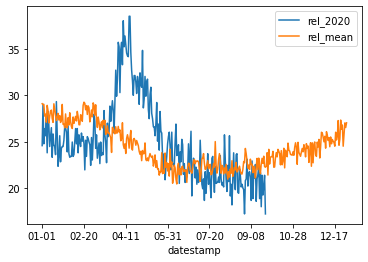

In [16]:
ax = df[['rel_2020','rel_mean']].plot()

(0.0, 40.0)

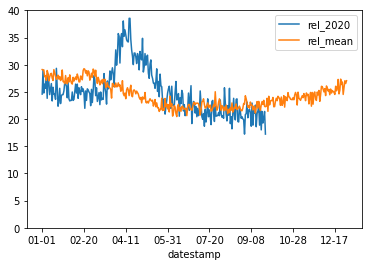

In [17]:
ax = df[['rel_2020','rel_mean']].plot()
ax.set_ylim((0,40))

<AxesSubplot:>

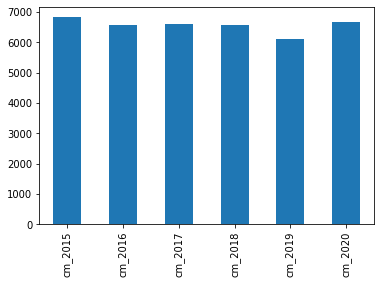

In [18]:
df.loc[border_date][cumulative].plot(kind='bar')

<AxesSubplot:xlabel='datestamp'>

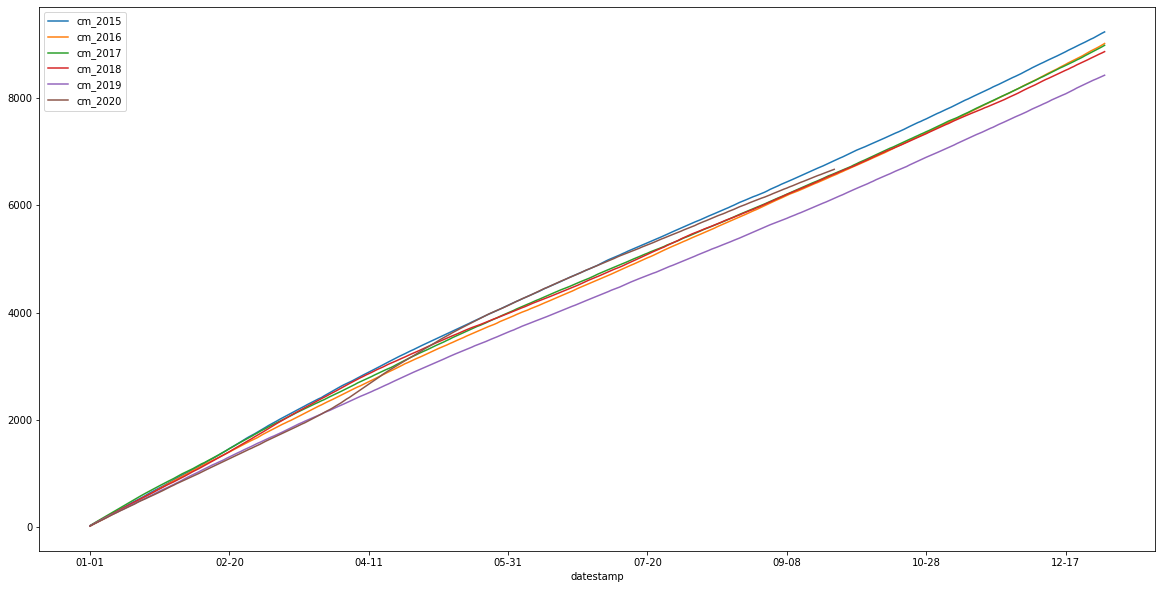

In [19]:
from matplotlib import pyplot as plt
_, ax = plt.subplots(1,1,figsize=(20,10))
df[cumulative].plot(ax=ax)

<AxesSubplot:xlabel='datestamp'>

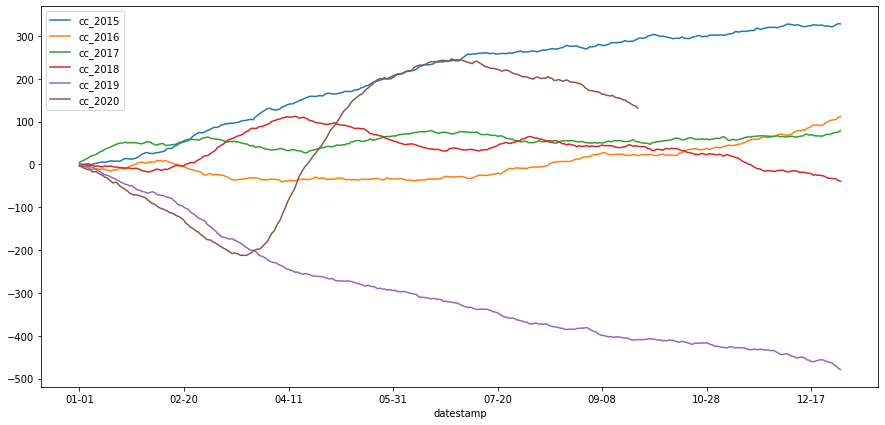

In [20]:
_, ax = plt.subplots(1,1,figsize=(15,7))
df[cumulative_corrected].plot(ax=ax)